### In this project, I developed a machine learning model aimed at predicting flight delays. The purpose of this analysis is not to obtain the most accurate model (since I don't have too much time to play with the data), but rather explore different relationships in the data and steps that are necessary in order to obtain such model. 
The dataset is seperated into 3 CSV files: airports, airlines, and candidate_dataset (more details about flights: delays, date, etc.).  
This notebook was ran using Google Colab to increase computational speed using their GPU.

In [2]:
#Mount my drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Change working directory to make it easier to access the files 
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/Everlaw")
os.getcwd() 

'/content/gdrive/My Drive/Colab Notebooks/Everlaw'

In [4]:
#Import libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adamax

Using TensorFlow backend.


## Loading the data

In [0]:
airlines=pd.read_csv('airlines.csv')
airports=pd.read_csv('airports.csv')
candidate_dataset=pd.read_csv('candidate_dataset.csv')

## Data exploration

In [6]:
#Airlines
print(airlines.describe())
print(airlines)
print(airlines.isnull().values.any()) #check for missing values

       IATA_CODE                 AIRLINE
count         14                      14
unique        14                      14
top           EV  Hawaiian Airlines Inc.
freq           1                       1
   IATA_CODE                       AIRLINE
0         UA         United Air Lines Inc.
1         AA        American Airlines Inc.
2         US               US Airways Inc.
3         F9        Frontier Airlines Inc.
4         B6               JetBlue Airways
5         OO         Skywest Airlines Inc.
6         AS          Alaska Airlines Inc.
7         NK              Spirit Air Lines
8         WN        Southwest Airlines Co.
9         DL          Delta Air Lines Inc.
10        EV   Atlantic Southeast Airlines
11        HA        Hawaiian Airlines Inc.
12        MQ  American Eagle Airlines Inc.
13        VX                Virgin America
False


It looks like we have 14 different airlines, each with a 2 letter code that represent it. No missing values. As for right now, I'll keep this dataset aside since it won't increase my predictions.

In [0]:
#Putting the this data in a dictionary- making it easier to get the airline's full name from its code
abbr_companies = airports.set_index(['IATA_CODE'],['AIRLINE']).to_dict()

In [8]:
#Airports
print(airports.head())
print(airports.isnull().values.any()) #check for missing values

  IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44906  -98.42183  
4  31.53552  -84.19447  
True


Looks like we have data on the coordinates of the airports (latitude+ longtitude). Notice that we have some missing values here. As for right now I'll set this dataset aside since in first glance I don't believe that the location of the airport has much to do with airlines delay, though if I'll see that the model needs more information about airports coordinates I might have to fill in/ drop the missing values.

In [9]:
#candidate_dataset
print(candidate_dataset.head())
print(candidate_dataset.isnull().values.any()) #check for missing values
print(candidate_dataset.isnull().sum())

   YEAR  MONTH  DAY  DAY_OF_WEEK AIRLINE  FLIGHT_NUMBER TAIL_NUMBER  \
0  2015      6    9            2      AA             92      N3LVAA   
1  2015      8   29            6      UA           1551      N76526   
2  2015      6    6            6      EV           4891      N137EV   
3  2015      1    6            2      DL           1719      N829DN   
4  2015      1    8            4      AS            322      N609AS   

  ORIGIN_AIRPORT DESTINATION_AIRPORT  SCHEDULED_DEPARTURE  DEPARTURE_TIME  \
0            LAS                 ORD                  841           840.0   
1            EWR                 TPA                 1529          1540.0   
2            MSN                 ATL                 1056          1054.0   
3            DTW                 LAX                 1200          1218.0   
4            SEA                 SJC                 1550          1645.0   

   DEPARTURE_DELAY  SCHEDULED_TIME  DISTANCE  SCHEDULED_ARRIVAL  ARRIVAL_TIME  \
0             -1.0           

This appears to be the main dataset. It has several features (categorical and numerical) that describe a date, an airline, and some info about the flight (delays, etc.). Notice that we have some missing values here.
One way to deal with missing values is to fill them with a constant or a mean of their class. Though, a more precise way for coping with missing values is using prediction, such as regression or classification. 
Since we don't have too many missing values (relatively to the size of the dataset) or too much time, I'll simply drop them in this case- though again, there are usually better methods to deal with such values


In [0]:
candidate_dataset.dropna(inplace=True) #dropping missing values

Note that in the dataset dates are labeled according to 4 variables: YEAR, MONTH, DAY, and DAY_OF_WEEK. Python has a datetime format which is really nice to work with and so I converted the dates to this format

In [11]:
candidate_dataset['DATE'] = pd.to_datetime(candidate_dataset[['YEAR','MONTH', 'DAY']])
candidate_dataset

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DATE
0,2015,6,9,2,AA,92,N3LVAA,LAS,ORD,841,840.0,-1.0,222.0,1514.0,1423,1416.0,-7.0,2015-06-09
1,2015,8,29,6,UA,1551,N76526,EWR,TPA,1529,1540.0,11.0,173.0,997.0,1822,1819.0,-3.0,2015-08-29
2,2015,6,6,6,EV,4891,N137EV,MSN,ATL,1056,1054.0,-2.0,116.0,707.0,1352,1340.0,-12.0,2015-06-06
3,2015,1,6,2,DL,1719,N829DN,DTW,LAX,1200,1218.0,18.0,310.0,1979.0,1410,1409.0,-1.0,2015-01-06
4,2015,1,8,4,AS,322,N609AS,SEA,SJC,1550,1645.0,55.0,121.0,697.0,1751,1854.0,63.0,2015-01-08
5,2015,7,5,7,AS,355,N588AS,SMF,SEA,1155,1158.0,3.0,105.0,605.0,1340,1339.0,-1.0,2015-07-05
6,2015,7,14,2,WN,885,N8329B,DEN,LAX,2055,2117.0,22.0,145.0,862.0,2220,2252.0,32.0,2015-07-14
7,2015,10,4,7,EV,4451,N12195,IAH,ECP,1145,1136.0,-9.0,113.0,572.0,1338,1319.0,-19.0,2015-10-04
8,2015,12,22,2,WN,314,N481WN,ATL,MDW,645,645.0,0.0,115.0,591.0,740,725.0,-15.0,2015-12-22
9,2015,10,21,3,WN,2313,N8314L,MDW,DEN,1010,1005.0,-5.0,155.0,895.0,1145,1140.0,-5.0,2015-10-21


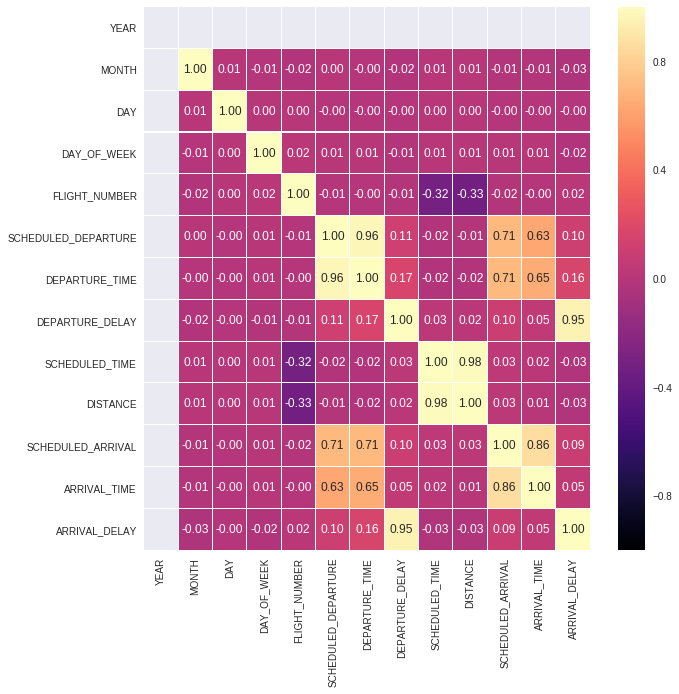

In [12]:
#Checking correlations
fig,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(candidate_dataset.corr(), ax=ax, annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")

The above heatmap shows correlations between variables. Removing redundant information in a model helps reduce multicollinearity so this is always important to check. Note that most of the variables does not have a very strong correlation with each other, however, some do.
Take distance and schedule_time for example. It is quite obvious that flights with higher distance travel will take longer time - hence this info is not too meaningful to us.

In [17]:
# Get the total count of delays grouped by airline

df_flights_grouped_sum = candidate_dataset.groupby('AIRLINE', as_index= False)['ARRIVAL_DELAY'].agg('sum').rename(columns={"ARRIVAL_DELAY":"ARRIVAL_DELAY_SUM"})
df_flights_grouped_cnt = candidate_dataset.groupby('AIRLINE', as_index= False)['ARRIVAL_DELAY'].agg('count').rename(columns={"ARRIVAL_DELAY":"ARRIVAL_DELAY_CNT"})

# Merge the two groups together
df_flights_grouped_delay = df_flights_grouped_sum.merge(df_flights_grouped_cnt, left_on='AIRLINE', right_on='AIRLINE', how='inner')
# Calculate the average delay per airline
df_flights_grouped_delay.loc[:,'AVG_DELAY_AIRLINE'] = df_flights_grouped_delay['ARRIVAL_DELAY_SUM'] / df_flights_grouped_delay['ARRIVAL_DELAY_CNT']

df_flights_grouped_delay.sort_values('ARRIVAL_DELAY_SUM', ascending=False)

,AIRLINE,ARRIVAL_DELAY_SUM,ARRIVAL_DELAY_CNT,AVG_DELAY_AIRLINE
13,WN,481212.0,106562,4.515794
4,EV,324891.0,48166,6.745235
9,OO,281342.0,49516,5.681840
10,UA,249223.0,43468,5.733482
0,AA,211488.0,61231,3.453937
7,MQ,166631.0,24002,6.942380
8,NK,145335.0,9714,14.961396
2,B6,144714.0,22214,6.514540
5,F9,93391.0,7681,12.158703
11,US,53063.0,16646,3.187733


Considering total delay, the above table shows that 'AS' airline has the least amount of arrival delay (it actually seems like it usually arrive sooner), while 'WN' has the most delay.
Though, if we consider average delay, it appears that again 'AS' has the least, but 'NK' has the most delay in flights on average

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Average arrival delay by airline')

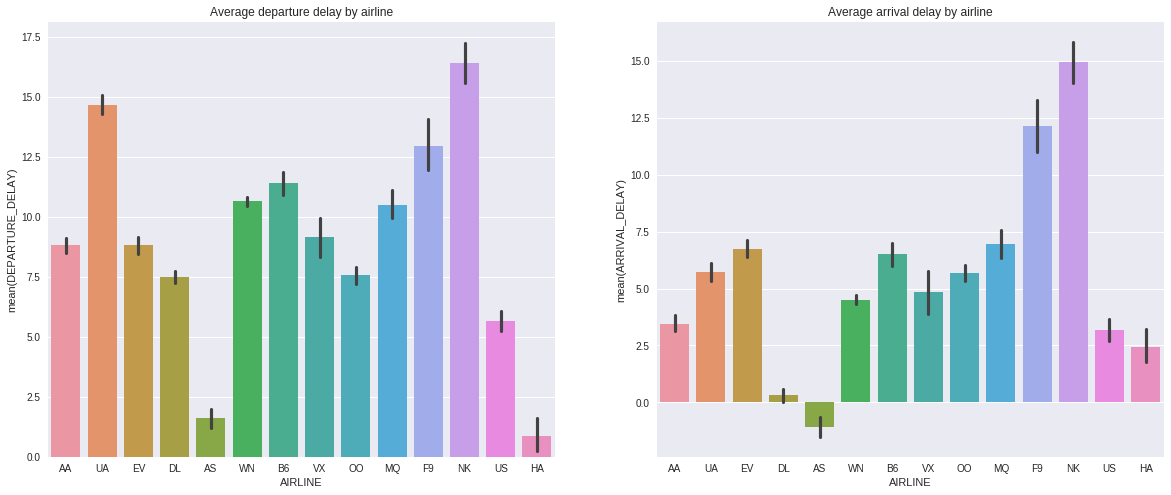

In [13]:
#We can see it better with some bar plots

f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('AIRLINE','DEPARTURE_DELAY', data=candidate_dataset,ax=ax[0])
ax[0].set_title('Average departure delay by airline')
sns.barplot('AIRLINE','ARRIVAL_DELAY', data=candidate_dataset,ax=ax[1])
ax[1].set_title('Average arrival delay by airline')

The above plots show the average delay by airline (departure and arrival). Note that airlines NK, and UA seem to have the highest delay in departures, while NK and F9 have the highest delay in arrivals (maybe don't fly with NK : )
Another interesting point here, is that AS airline seem to have the second lowest departures delay, and it is the only airline that on average arrive sooner than expected. 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5, 1.0, 'Average arrival delay by day')

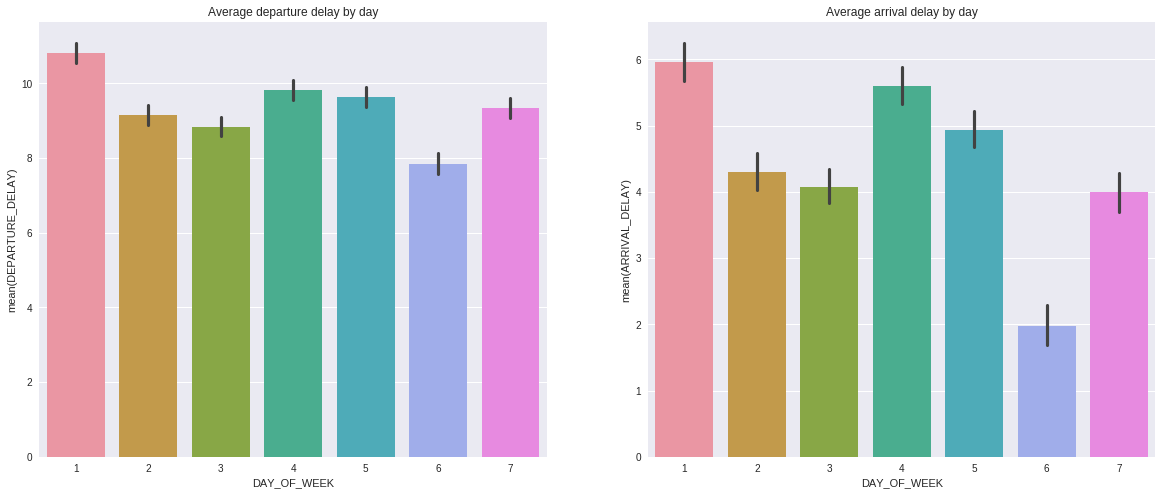

In [14]:
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('DAY_OF_WEEK','DEPARTURE_DELAY', data=candidate_dataset,ax=ax[0])
ax[0].set_title('Average departure delay by day')
sns.barplot('DAY_OF_WEEK','ARRIVAL_DELAY', data=candidate_dataset,ax=ax[1])
ax[1].set_title('Average arrival delay by day')

I was always interested in which day I should schedule my flights to. It appears like sundays have the highest delay in both departures and arrivals on average, followed by wednesday and thursday.

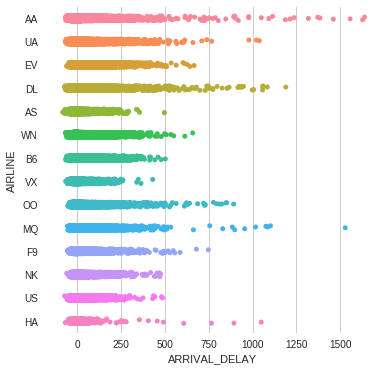

In [15]:
#Distribution of arrival delay
sns.set(style="whitegrid")

# initialize the figure
fig_dim = (6,6)
f, ax = plt.subplots(figsize=fig_dim)
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(x="ARRIVAL_DELAY", y="AIRLINE",
              data=candidate_dataset, jitter=True
            )

The above figure shows the distribution of airlines in comparison to their arrival delays. Note that AA has a wide spread of delays.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


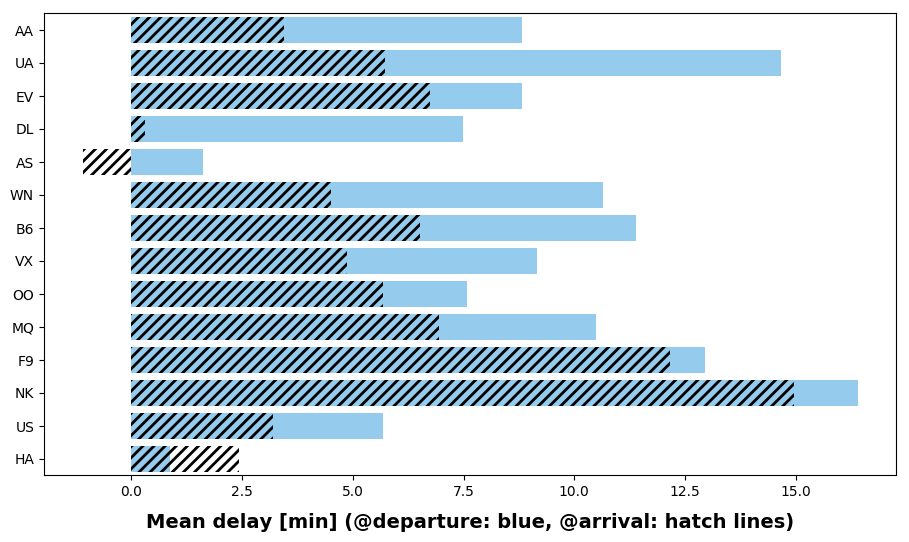

In [18]:
#bar plots
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['hatch.linewidth'] = 2.0  

fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="DEPARTURE_DELAY", y="AIRLINE", data=candidate_dataset, color="lightskyblue", ci=None)
ax = sns.barplot(x="ARRIVAL_DELAY", y="AIRLINE", data=candidate_dataset, color="r", hatch = '///',
                 alpha = 0.0, ci=None)
ax.yaxis.label.set_visible(False)
plt.xlabel('Mean delay [min] (@departure: blue, @arrival: hatch lines)',
           fontsize=14, weight = 'bold', labelpad=10);

The above figure shows that delays in arrival are usually lower than delays in departure. This can be a result of many things, one of such is that pilots adjust their flight speed in order to reduce the delays at arrival.

## Predicting flight delays

In the previous section I explored the dataset. Here, I start developing a model that predicts arrival delay. I'm wondering, assuming there's a flight that was delayed in departure, will the pilot try to compensate and arrive sooner? Does a delay in departure always result in delay in arrival? I believe than a machine learning model can provide some insights and find patterns in this data.
I will start with a simple linear regression model followed by neural network.
A reason why I choose neural network to begin with, is that I found they are pretty good in linear regression problems. And since I'm trying to predict a numerical value (arrival delay), they seem to fit well.
Note that Linear Regression might be old but it’s still useful. There’s a drawback of using linear regression because it’s made on assumptions that our data have linear relationships while in many real world scenarios that not true.

In [0]:
#Organize the data 
x=candidate_dataset[['MONTH', 'DAY','DAY_OF_WEEK', 'FLIGHT_NUMBER', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_TIME', 'DISTANCE','SCHEDULED_ARRIVAL']]
y=candidate_dataset['ARRIVAL_DELAY']

In [0]:
#Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [25]:
#Lets try a simple model first

from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score

clf = LinearRegression(normalize=True)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print(r2_score(y_test,y_pred))

0.06638133693204895


I used scikit learn to import the linear regression model. I fit the model on the training data and predict the values for the testing data. Then I use R2 score to measure the accuracy of the model.
Notice the extremely low R2 score that tells us that the model explains almost none of the variability of the response data around its mean.
Let's try a more complex model.

Now, we train the neural network. We are using the 9 input variables (can see above in 'x'), along with two hidden layers of 12 and 8 neurons respectively, and finally using the linear activation function to process the output.

In [21]:
#Linear Regression Model

#define the model
lr_model = Sequential()
lr_model.add(Dense(12, input_shape=(x_train.shape[1],), activation='relu'))
lr_model.add(Dense(8, activation='relu'))
lr_model.add(Dense(1, activation='linear'))
lr_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                120       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


The mean_squared_error (mse) and mean_absolute_error (mae) are our loss functions – i.e. an estimate of how accurate the neural network is in predicting the test data. We can see that with the validation_split set to 0.2, 80% of the training data is used to test the model, while the remaining 20% is used for testing purposes.

In [23]:

#compile
lr_model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

#fit
history = lr_model.fit(x_train, y_train, epochs=10, batch_size=10,  verbose=1, validation_split=0.2)

#lr_history = lr_model.fit(x_train, y_train, verbose=1, epochs=10)
#plot_loss_accuracy(lr_history)

Train on 314212 samples, validate on 78553 samples
Epoch 1/10
314212/314212 [==============================] - 128s 407us/step - loss: 569.2779 - mean_squared_error: 569.2779 - mean_absolute_error: 13.5080 - val_loss: 339.7614 - val_mean_squared_error: 339.7614 - val_mean_absolute_error: 10.8147
Epoch 2/10
314212/314212 [==============================] - 128s 407us/step - loss: 387.8402 - mean_squared_error: 387.8402 - mean_absolute_error: 11.2783 - val_loss: 429.5121 - val_mean_squared_error: 429.5121 - val_mean_absolute_error: 12.7264
Epoch 3/10
314212/314212 [==============================] - 128s 406us/step - loss: 346.6096 - mean_squared_error: 346.6096 - mean_absolute_error: 10.7943 - val_loss: 316.9543 - val_mean_squared_error: 316.9543 - val_mean_absolute_error: 9.9790
Epoch 4/10
314212/314212 [==============================] - 128s 407us/step - loss: 306.3811 - mean_squared_error: 306.3811 - mean_absolute_error: 10.6836 - val_loss: 351.7584 - val_mean_squared_error: 351.7584 -

Here, we can see that keras is calculating both the training loss and validation loss, i.e. the deviation between the predicted y and actual y as measured by the mean squared error.

As you can see, I have specified 10 epochs for our model. This means that we are essentially training our model over 10 forward and backward passes, with the expectation that our loss will decrease with each epoch, meaning that our model is predicting the value of y more accurately as we continue to train the model.
Let’s see what this looks like when we plot our respective losses:

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


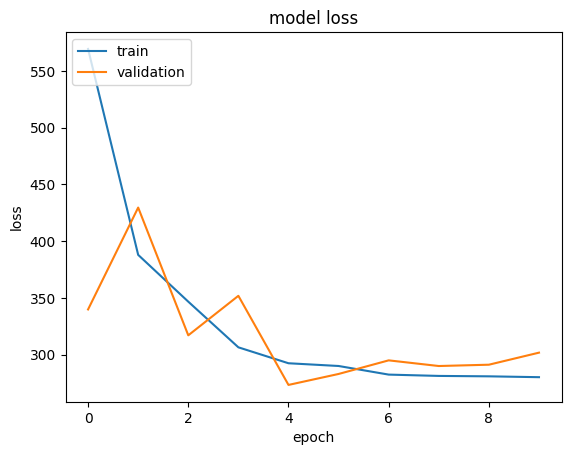

In [24]:
#Plotting the loss
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Note that the trainig loss decreases exponentially while the validation loss decreases but also "jumps" around (though eventually seems to converge). This seems to be an issue with the learning rate/possibly other hyperparameters. Given more time I'd typically run a grid search on a neural network to get the optimal hyperparameters.

## Summary

This analysis provided some insights about the data, as well as some relationships between variables.
There are clearly plenty more things that could have been done to explore the data, as well as improving the model at the end.
Given more time I would explore other techniques to improve predictions such as feature selection, converting categorical variables, grid search, regularization methods, etc.
I hope that the data exploration part was clear, concise, and colorful, and that the machine learning model provided some insights on one approach to deal with such data.
Please feel free to ask me any questions in regards to my code and approach.

Sagi